In [1]:
import numpy as np
from numpy import genfromtxt, savetxt
from simulators import Warburton_Simulator
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy.stats import cauchy
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [7, 5]

In [22]:
QD_data = genfromtxt('Data/PowerSpectralDensity.csv', delimiter=',')
QD_data = QD_data[QD_data[:,0].argsort()]
QD_f_data = QD_data.T[0]
QD_p_data = QD_data.T[1]
QD_f_data_log = np.log(QD_f_data)
QD_p_data_log = np.log(QD_p_data)
QD_degrees = 15
QD_poly_fit_params = np.polyfit(QD_f_data_log,QD_p_data_log,QD_degrees)
def QD_poly_fit(f_log):
    p_log = 0
    for i in range(QD_degrees+1):
        p_log += QD_poly_fit_params[QD_degrees-i]*np.power(f_log,i)
    return p_log

In [23]:
LF_data = genfromtxt('Data/Nexp.csv', delimiter=',')
LF_data = LF_data[LF_data[:,0].argsort()]
LF_f_data = LF_data.T[0]
LF_p_data = LF_data.T[1]
LF_f_data_log = np.log(LF_f_data)
LF_p_data_log = np.log(LF_p_data)
LF_degrees = 1
LF_poly_fit_params = np.polyfit(LF_f_data_log,LF_p_data_log,LF_degrees)
def LF_poly_fit(f_log):
    p_log = 0
    for i in range(LF_degrees+1):
        p_log += LF_poly_fit_params[LF_degrees-i]*np.power(f_log,i)
    return p_log

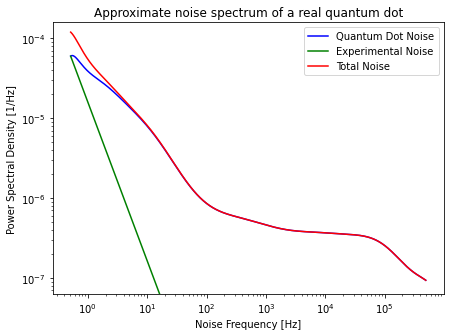

In [24]:
f_min = 0.51414021774167812 # Must be greater that 0.5414 Hz
f_max = 493318.9182771271 # Do not adjust
num_sources = 1000
f_vals_log = np.linspace(np.log(f_min),np.log(f_max),num_sources)
f_vals = np.exp(f_vals_log)
QD_p_vals_log = QD_poly_fit(f_vals_log)
QD_p_vals = np.exp(QD_p_vals_log)
LF_p_vals_log = LF_poly_fit(f_vals_log)
LF_p_vals = np.exp(LF_p_vals_log)
p_vals = QD_p_vals + LF_p_vals

plt.rcParams['figure.figsize'] = [7, 5]
plt.xscale("log")
plt.ylim([10**-7.2,10**-3.8])
plt.yscale("log")
plt.plot(f_vals,QD_p_vals,color='blue',label='Quantum Dot Noise')
plt.plot(f_vals,LF_p_vals,color='green',label='Experimental Noise')
plt.plot(f_vals,p_vals,color='red',label='Total Noise')
plt.title("Approximate noise spectrum of a real quantum dot")
plt.xlabel("Noise Frequency [Hz]")
plt.ylabel("Power Spectral Density [1/Hz]")
plt.legend()

In [81]:
N = 1000
integrals = np.zeros(N)
f_int = np.logspace(np.log(f_min),np.log(f_max),N,base=np.e)
f_int_log = np.log(f_int)
QD_p_int_log = QD_poly_fit(f_int_log)
LF_p_int_log = LF_poly_fit(f_int_log)
p_int = np.exp(QD_p_int_log) + np.exp(LF_p_int_log)

STDs = np.zeros(N)
for j in range(N):
    integrals = np.zeros(N-1-j)
    for i in range(N-1-j):
        m = np.log(p_int[i+j]/p_int[i+j+1])/np.log(f_int[i+j]/f_int[i+j+1])
        b = np.log(p_int[i+j]) - m*np.log(f_int[i+j])
        if (-1.0001 < m < -0.9999):
            integrals[i] = np.exp(b)*(np.log(f_int[i+j+1]/f_int[i+j]))
        else:
            integrals[i] = (np.exp(b)/(m+1))*(np.power(f_int[i+j+1],m+1)-np.power(f_int[i+j],m+1))
    var = np.sum(integrals)
    STDs[j] = (np.sqrt(var))

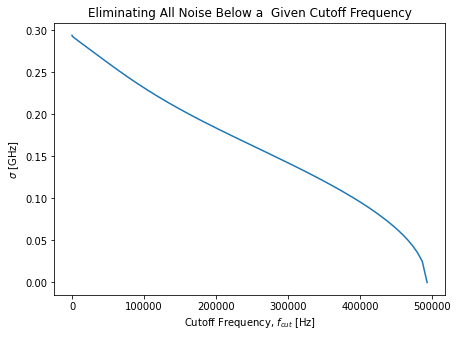

In [85]:
plt.title("Eliminating All Noise Below a  Given Cutoff Frequency")
plt.xlabel("Cutoff Frequency, $f_{cut}$ [Hz]")
plt.ylabel("$\sigma$ [GHz]")

plt.plot(f_int,STDs)

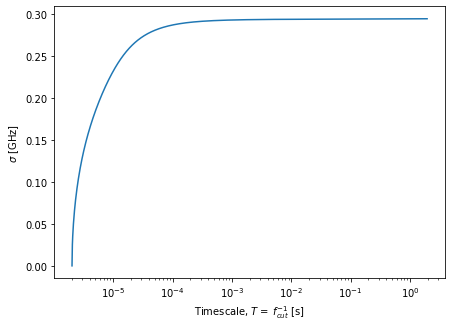

In [101]:
timescales = 1.0/f_int
plt.xscale("log")
#plt.title("Eliminating All Noise Below a Given Cutoff Frequency")
plt.xlabel("Timescale, $T$$=$ $f_{cut}^{-1}$ [s]")
plt.ylabel("$\sigma$ [GHz]")
plt.plot(timescales,STDs)

## Simulated way

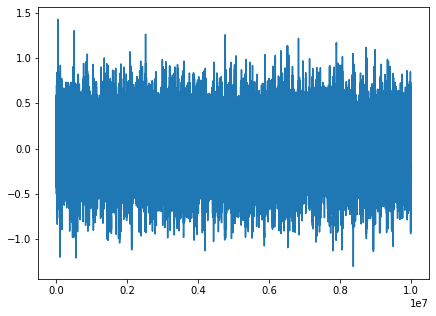

In [58]:
centers = genfromtxt('Data/AllNoiseSimulatedData.csv', delimiter=',')
plt.plot(centers)

In [74]:
total_time = 500
timestep = 0.00005
num_steps = int(total_time/timestep)
num_locations = 1000
locations = np.linspace(0,num_steps-5./timestep,num_locations)
locations = locations.astype("int")

num_windows = 50
window_steps = np.linspace(2,40000,num_windows)
window_steps = np.logspace(0.69,10.6,num_windows,base=np.e)
window_steps = window_steps.astype("int")
windows = window_steps*timestep

STDs = np.zeros(num_windows)

for i in range(num_windows):
    std = np.zeros(num_locations)
    for j in range(num_locations):
        std[j] = np.std(centers[locations[j]:locations[j]+window_steps[i]])
    STDs[i] = np.mean(std)

Text(0, 0.5, '$\\sigma$ [GHz]')

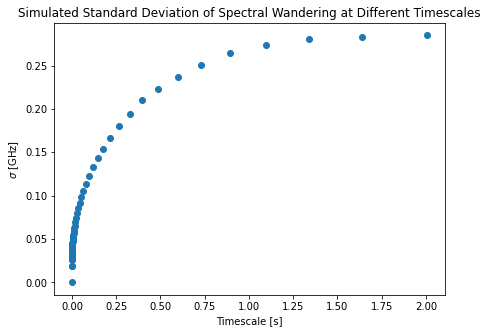

In [79]:
#plt.scatter(windows,RMSEs)
plt.scatter(windows,STDs)
#plt.xscale("log")
plt.title("Simulated Standard Deviation of Spectral Wandering at Different Timescales")
plt.xlabel("Timescale [s]")
plt.ylabel("$\sigma$ [GHz]")

In [57]:
print(np.std(centers))

0.2902662592899901
